In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np


In [64]:
cornbelters_files = glob.glob("../KCLData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
stuff_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(stuff_plus, ignore_index=True)


In [65]:
dft = df[['PitchUUID','PlayResult','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak']]

In [66]:
dft = dft.dropna()


In [67]:
dft['PlayResult'].unique()


array(['StrikeoutLooking', 'StrikeoutSwinging', 'Out', 'Single', 'Error',
       'Walk', 'Triple', 'Double', 'HomeRun', 'FieldersChoice',
       'Sacrifice'], dtype=object)

In [68]:
map_data = {
    'StrikeoutLooking': 1,
    'StrikeoutSwinging': 1,
    'Out': 1,
    'Single': 0,
    'Double': 0,
    'Error': 0,
    'Walk': 0,
    'Triple': 0,
    'HomeRun': 0,
    'FieldersChoice': 0,
    'Sacrifice': 0
}

dft['PlayResult'] = dft['PlayResult'].map(map_data)

In [69]:
features = ['RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak']

In [70]:
X = dft[features]
y = dft['PlayResult']

In [71]:
def CV():
    k_scores = {}
    for i in range(1,30):
        xba_model = KNeighborsRegressor(n_neighbors = i)
        k_folds = KFold(n_splits = 5)
        scores = cross_val_score(xba_model, X, y, cv = k_folds, scoring = 'neg_root_mean_squared_error') * -1
        k_scores[i] = scores.mean()
    return k_scores

scores = CV()

Text(0, 0.5, 'RMSE')

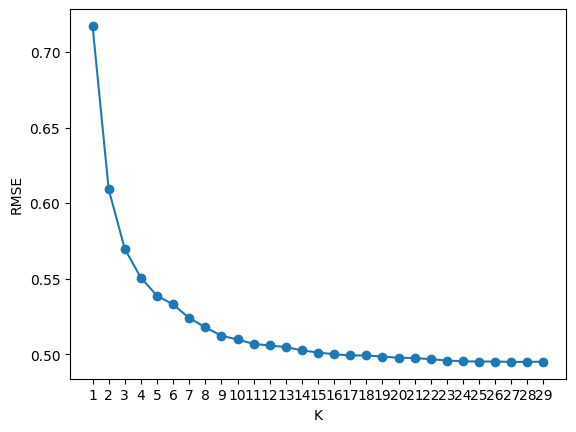

In [72]:
K_vals = scores.keys()
RMSE_vals = scores.values()
plt.scatter(K_vals,RMSE_vals)
plt.plot(K_vals,RMSE_vals)
plt.xticks([i for i in range(1,30)])
plt.xlabel("K")
plt.ylabel("RMSE")

In [73]:
stuff_plus_model = KNeighborsRegressor(n_neighbors = 15)
stuff_plus_model.fit(X,y)

KNeighborsRegressor(n_neighbors=15)

In [74]:
from itertools import product

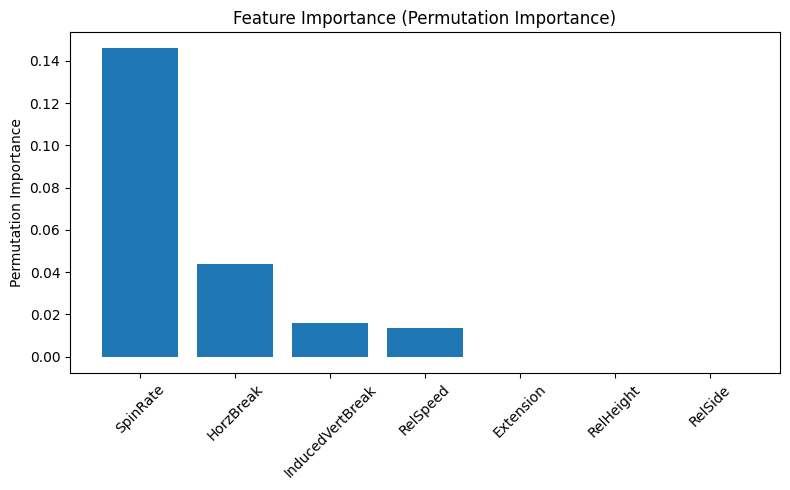

In [75]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculate permutation importance
result = permutation_importance(stuff_plus_model, X, y, n_repeats=10, random_state=42)

# Get importances and sort
importances = result.importances_mean
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.ylabel("Permutation Importance")
plt.title("Feature Importance (Permutation Importance)")
plt.tight_layout()
plt.show()

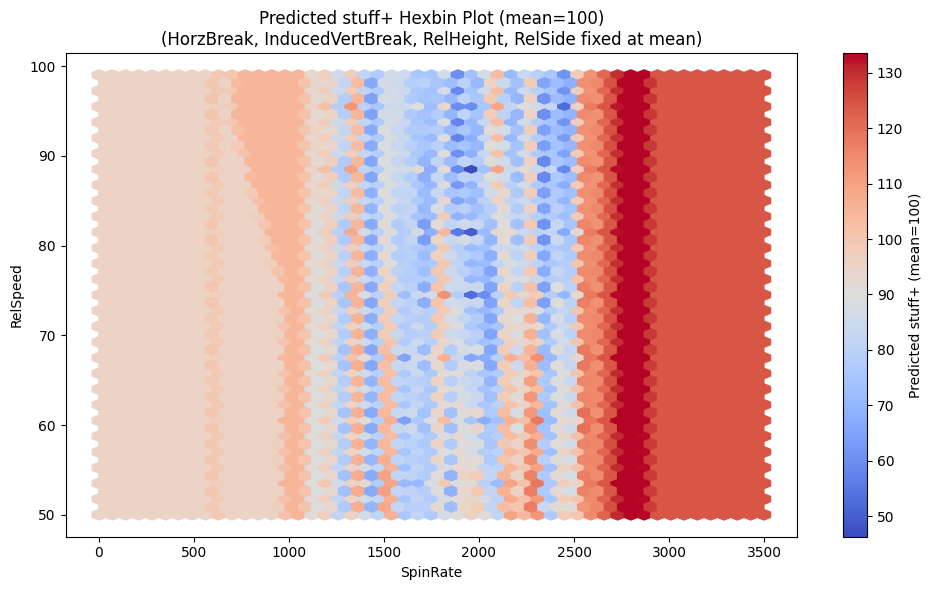

In [76]:
from itertools import product

# Get mean values for the additional features
mean_horzbreak = X['HorzBreak'].mean()
mean_inducedvertbreak = X['InducedVertBreak'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()

# Create grid for SpinRate and RelSpeed, fix other features at their mean
spin_rate = range(0, 3500, 1)
relspeed = range(50, 100, 1)
combinations = list(product(spin_rate, relspeed))

sim_data = pd.DataFrame(combinations, columns=['SpinRate', 'RelSpeed'])
sim_data['HorzBreak'] = mean_horzbreak
sim_data['InducedVertBreak'] = mean_inducedvertbreak
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = stuff_plus_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['SpinRate'],
    sim_data['RelSpeed'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("SpinRate")
plt.ylabel("RelSpeed")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(HorzBreak, InducedVertBreak, RelHeight, RelSide fixed at mean)")
plt.tight_layout()
plt.show()

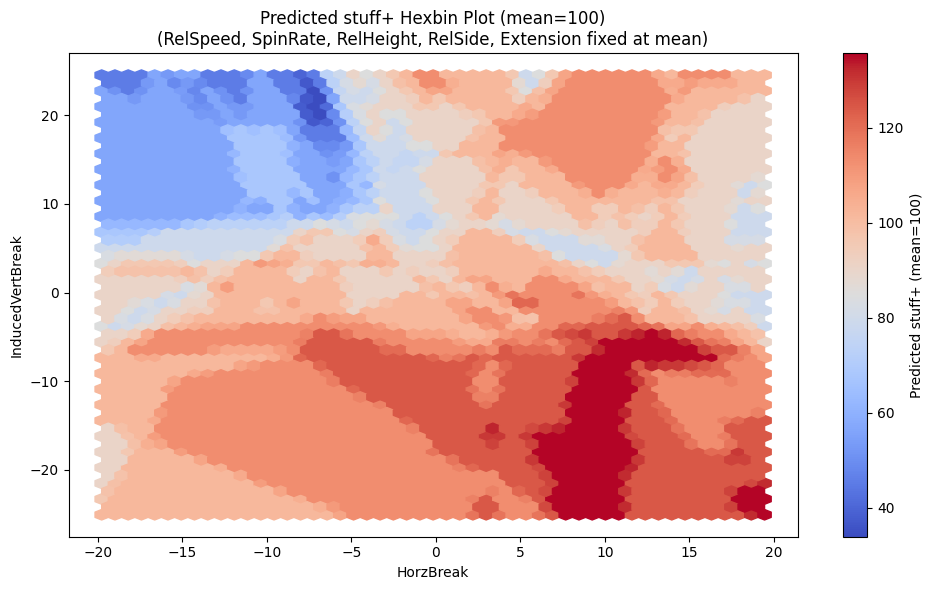

In [77]:
from itertools import product

# Get mean values for the other features
mean_relspeed = X['RelSpeed'].mean()
mean_spinrate = X['SpinRate'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()

# Create grid for InducedVertBreak and HorzBreak, fix other features at their mean
induced_vert_break = np.linspace(X['InducedVertBreak'].min(), X['InducedVertBreak'].max(), 100)
horz_break = np.linspace(X['HorzBreak'].min(), X['HorzBreak'].max(), 100)
combinations = list(product(induced_vert_break, horz_break))

sim_data = pd.DataFrame(combinations, columns=['InducedVertBreak', 'HorzBreak'])
sim_data['RelSpeed'] = mean_relspeed
sim_data['SpinRate'] = mean_spinrate
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = stuff_plus_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['HorzBreak'],
    sim_data['InducedVertBreak'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("HorzBreak")
plt.ylabel("InducedVertBreak")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(RelSpeed, SpinRate, RelHeight, RelSide, Extension fixed at mean)")
plt.tight_layout()

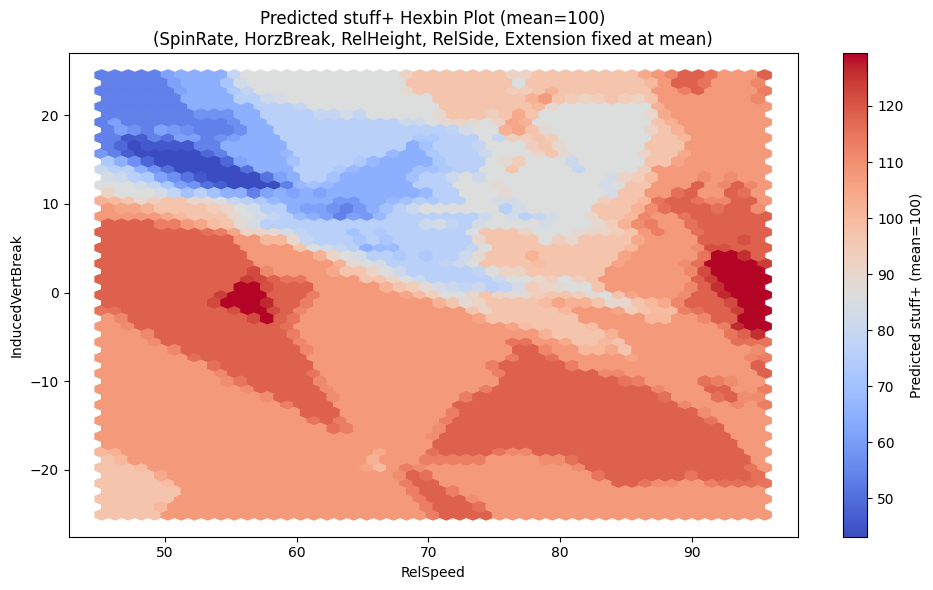

In [78]:
from itertools import product

# Get mean values for the other features
mean_spinrate = X['SpinRate'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()
mean_horzbreak = X['HorzBreak'].mean()

# Create grid for InducedVertBreak and RelSpeed, fix other features at their mean
induced_vert_break = np.linspace(X['InducedVertBreak'].min(), X['InducedVertBreak'].max(), 100)
relspeed = np.linspace(X['RelSpeed'].min(), X['RelSpeed'].max(), 100)
combinations = list(product(induced_vert_break, relspeed))

sim_data = pd.DataFrame(combinations, columns=['InducedVertBreak', 'RelSpeed'])
sim_data['SpinRate'] = mean_spinrate
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension
sim_data['HorzBreak'] = mean_horzbreak

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = stuff_plus_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['RelSpeed'],
    sim_data['InducedVertBreak'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("RelSpeed")
plt.ylabel("InducedVertBreak")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(SpinRate, HorzBreak, RelHeight, RelSide, Extension fixed at mean)")
plt.tight_layout()

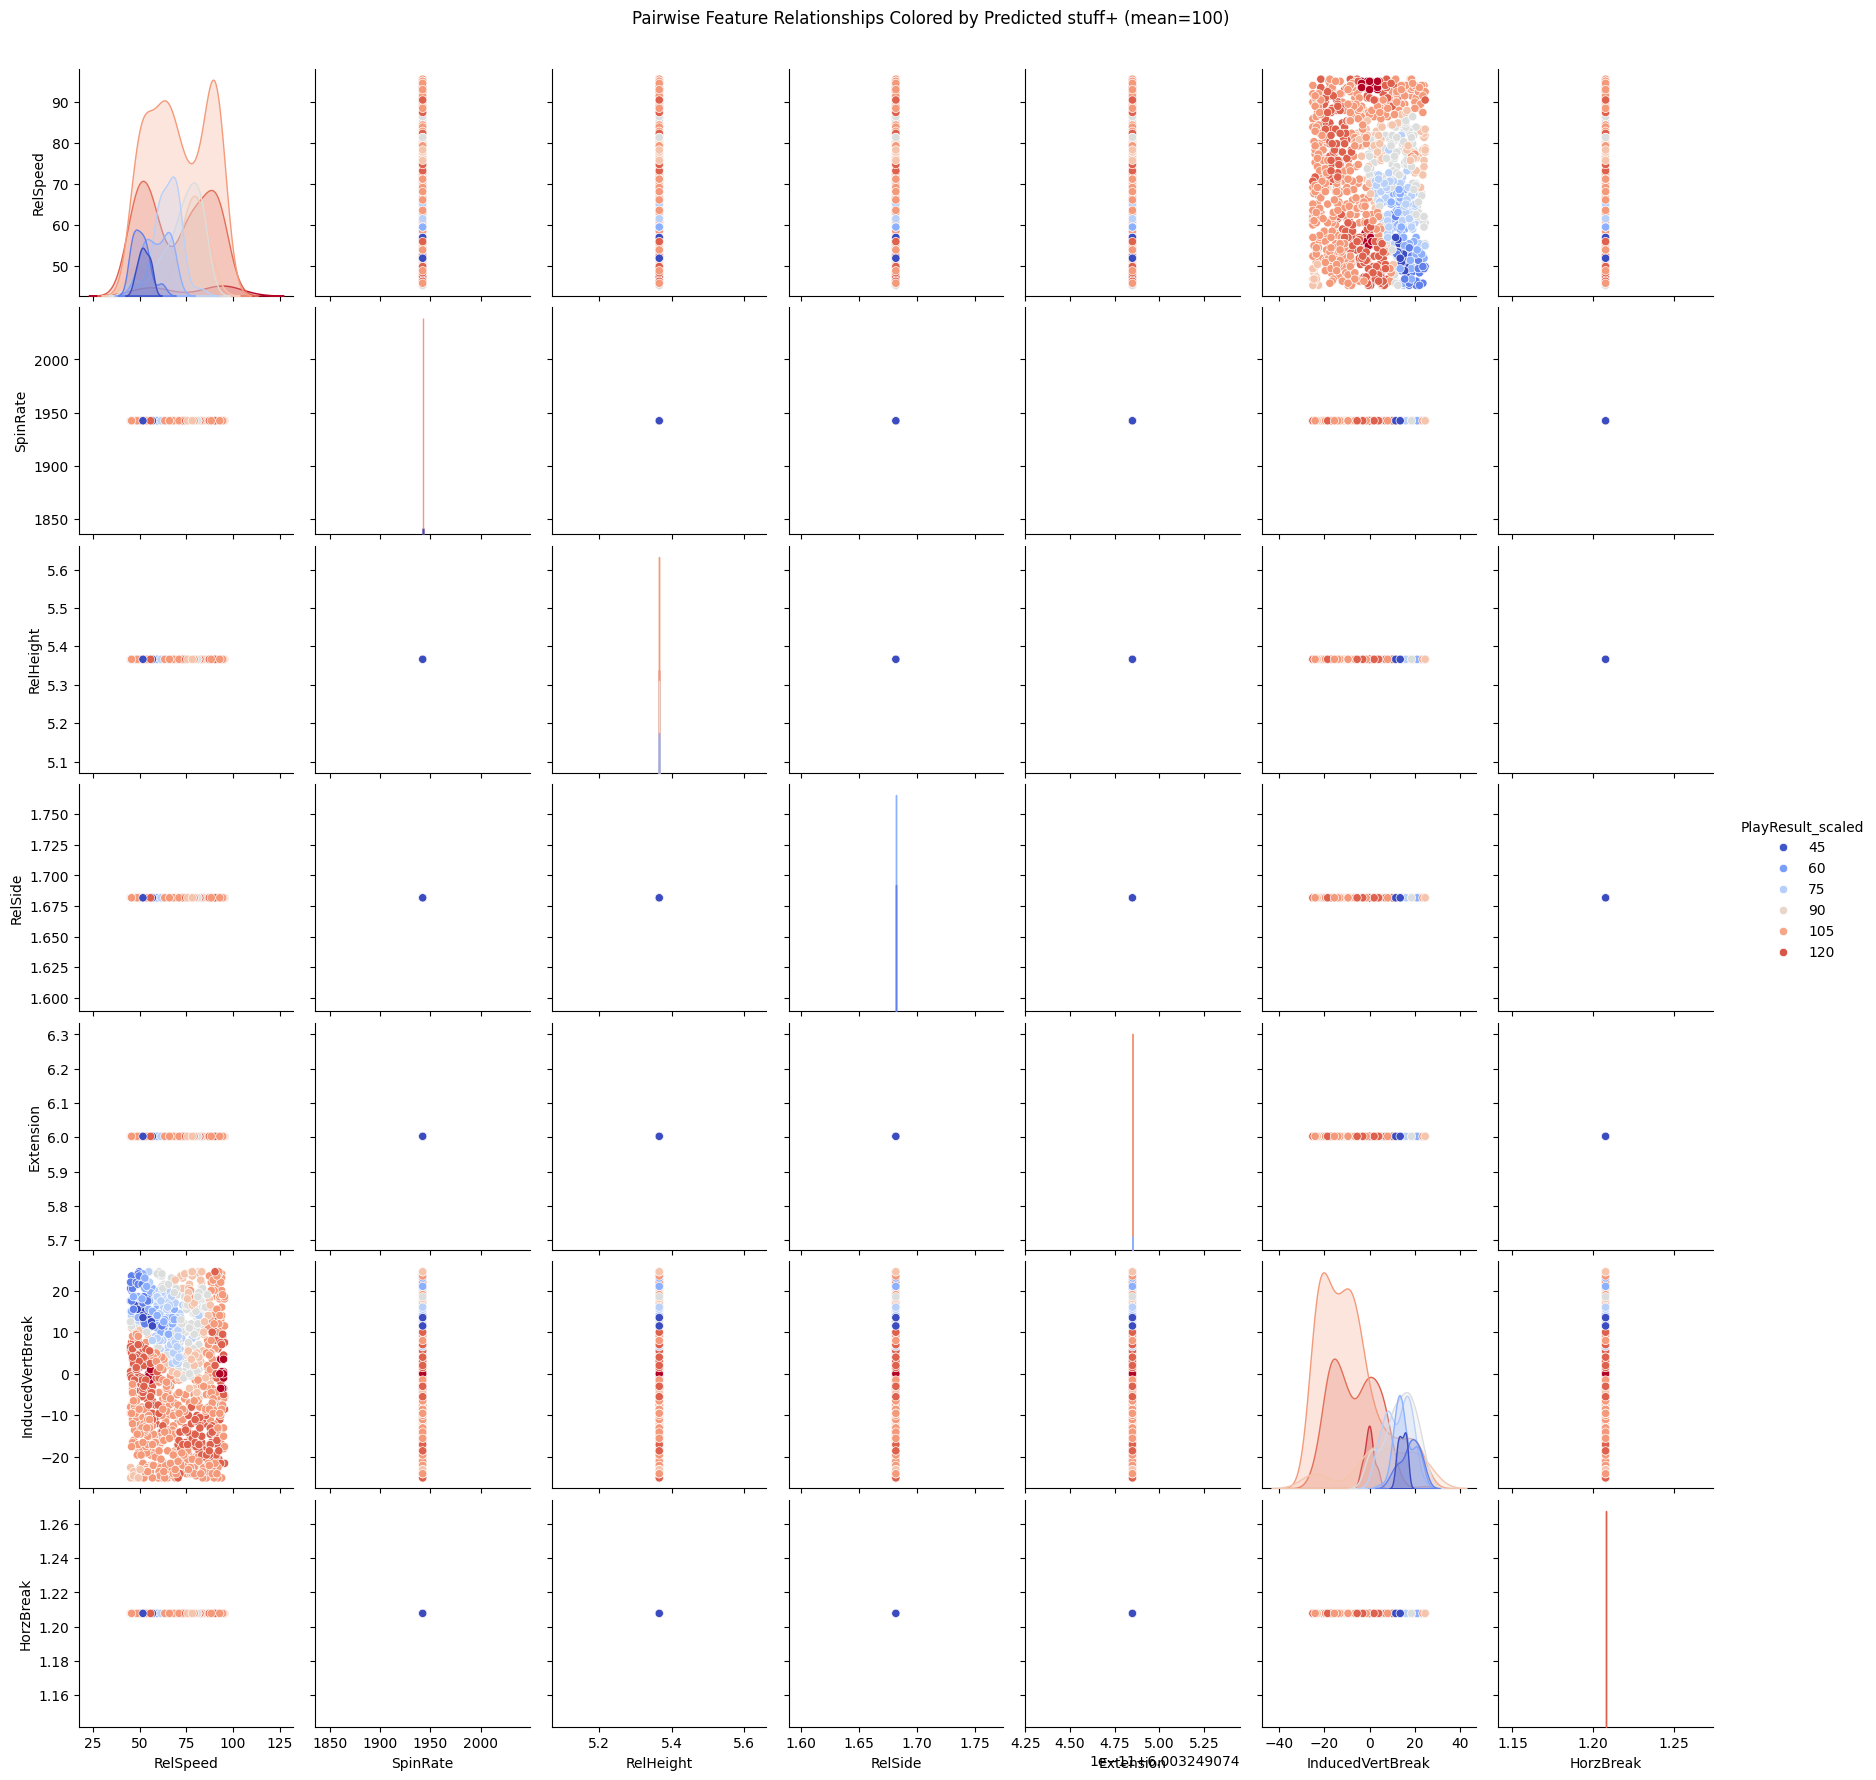

In [79]:
import seaborn as sns

# Sample a subset for visualization if your data is large
sampled = sim_data.sample(n=1000, random_state=42)

# Add the scaled prediction to the DataFrame if not already present
# sampled['PlayResult_scaled'] = sampled['PlayResult'] * (100 / sampled['PlayResult'].mean())

sns.pairplot(sampled, vars=['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak'],
             hue='PlayResult_scaled', palette='coolwarm')
plt.suptitle("Pairwise Feature Relationships Colored by Predicted stuff+ (mean=100)", y=1.02)
plt.show()

In [80]:
def predict_stuff_plus(event):
    # Make sure all required features are present
    features = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']
    if all(f in event and not pd.isna(event[f]) for f in features):
        # Predict using the trained model
        pred = stuff_plus_model.predict([[event[f] for f in features]])[0]
        # Scale so mean is 100 (use your training mean or pass as argument if needed)
        mean_playresult = y.mean()  # or use a fixed value if you want
        return pred * (100 / mean_playresult)
    else:
        return np.nan  # Not enough data to predict

In [ ]:

cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)

In [85]:
# event should be a dict or Series with the 7 features
import warnings
warnings.filterwarnings("ignore")
kcl_df['stuff+'] = df.apply(predict_stuff_plus, axis = 1)
cornbelters_df['stuff+'] = df.apply(predict_stuff_plus, axis = 1)
kcl_df.to_csv("kcl_stuff+_data.csv", index=False)
cornbelters_df.to_csv("cornbelters_stuff+_data.csv", index=False)

In [83]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("cornbelters_stuff+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean stuff+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("stuff+", "count"),
        stuff_plus_mean=("stuff+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["stuff+_percentile"] = result["stuff_plus_mean"].rank(pct=True)

# Sort by stuff+ descending
result = result.sort_values("stuff_plus_mean", ascending=False)

# Show the result
result.to_csv("cornbelters_stuff+_pitcher_ranking.csv", index=False)

In [84]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("kcl_stuff+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean stuff+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("stuff+", "count"),
        stuff_plus_mean=("stuff+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["stuff+_percentile"] = result["stuff_plus_mean"].rank(pct=True)

# Sort by stuff+ descending
result = result.sort_values("stuff_plus_mean", ascending=False)

# Show the result
result.to_csv("kcl_stuff+_pitcher_ranking.csv", index=False)

In [86]:
import pickle

In [87]:
with open("stuff_plus_model.pkl", "wb") as f:
    pickle.dump(stuff_plus_model, f)

In [88]:
y.mean()

np.float64(0.5843009753831863)